# Scott Breitbach

# Feature Selection and Model Evaluation

In [1]:
# Load Libraries
import pandas as pd
import numpy as np

### Load Data

In [2]:
# Load data to a DataFrame
beanDF = pd.read_excel('data/Dry_Bean_Dataset.xlsx')

In [3]:
# Look at the shape of the DataFrame
beanDF.shape

(13611, 17)

In [4]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

Not all of the target categories are the same size, which I will leave as is for now, but I may need to adjust later by sampling / resampling.

### Feature Selection

#### Lowest Variance

Features with low variance will have less information. Note that features should be scaled prior to comparing variance.

In [5]:
# Load libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create scaler
minmax_scale = MinMaxScaler(feature_range=(0,1))

# Scale features
scaled_features = minmax_scale.fit_transform(features)

# Create thresholder
thresholder = VarianceThreshold()

# Create high-variance feature matrix
features_high_variance = thresholder.fit_transform(scaled_features)

# Look at features, sorted by variance (highest to lowest)
d = {'Column': features.columns, 'Variance': thresholder.fit(scaled_features).variances_}
varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
varianceDF

,Column,Variance
13,ShapeFactor2,0.036926
11,Compactness,0.031678
4,AspectRation,0.030804
14,ShapeFactor3,0.030760
8,Extent,0.024929
2,MajorAxisLength,0.023817
12,ShapeFactor1,0.021609
1,Perimeter,0.021522
7,EquivDiameter,0.021022
3,MinorAxisLength,0.017733


In [6]:
# Make a list of columns with variance less than 10e-2
low_var = varianceDF['Column'][(varianceDF['Variance'] < 1.6e-2)].tolist()

# Features to drop
print("Features with low variance:\n", low_var)

Features with low variance:
 ['Area', 'ConvexArea', 'roundness', 'ShapeFactor4', 'Solidity']


Here I have set the 5 features with the lowest variance to potentially be removed.

#### Least Informative

In [7]:
## USE ANOVA F-VALUE TO FIND THE MOST INFORMATIVE FEATURES

# Load libraries
# from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import SelectPercentile

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Select the n features with the highest F-values
fvalue_selector = SelectKBest(f_classif, k=11)
features_kbest = fvalue_selector.fit_transform(features, target)

# # Select top 75% of features with highest F-values
# fvalue_selector = SelectPercentile(f_classif, percentile=75)
# features_kbest = fvalue_selector.fit_transform(features, target)

# Look at first row of best features
features_kbest[0]

array([2.83950000e+04, 6.10291000e+02, 2.08178117e+02, 1.73888747e+02,
       1.19719142e+00, 2.87150000e+04, 1.90141097e+02, 9.13357755e-01,
       7.33150614e-03, 3.14728917e-03, 8.34222388e-01])

In [8]:
# Make a list of the low information features
low_inf = features.columns[~features.iloc[0].isin(features_kbest[0])].tolist()

# Features to drop
print("Features with low information:\n", low_inf)

Features with low information:
 ['Eccentricity', 'Extent', 'Solidity', 'roundness', 'ShapeFactor4']


Again I have selected the 5 features considered least useful, this time based on F-values.

#### Recursively Eliminate Features Using Cross-Validation

In [9]:
# Load libraries
import warnings
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model

In [10]:
## ENCODE CATEGORICAL TARGET COLUMN

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Encode categorical target variable 'Class'
class_encoded = ord_enc.fit_transform(beanDF[['Class']])

In [11]:
# Create features and target
features = beanDF.select_dtypes(include='number')
target = class_encoded

# Create a linear regression
ols = linear_model.LinearRegression()

# Recursively eliminate features
rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

array([[0.00314729],
       [0.00356362],
       [0.00304773],
       ...,
       [0.00188827],
       [0.00185203],
       [0.00163981]])

In [12]:
# Number of best features
rfecv.n_features_

1

Curiously this suggests that I have 1 best feature. I will come back to this later to evaluate.

In [13]:
# Rank features best (1) to worst
rfecv.ranking_

array([15, 13, 14, 11,  6,  8, 16, 12, 10,  5,  7,  3,  2,  1,  4,  9])

In [14]:
# Rank features best to worst (from RFECV)
d = {'Features': features.columns, 'Rank': rfecv.ranking_}
ranked = pd.DataFrame(d).sort_values('Rank')
ranked

,Features,Rank
13,ShapeFactor2,1
12,ShapeFactor1,2
11,Compactness,3
14,ShapeFactor3,4
9,Solidity,5
4,AspectRation,6
10,roundness,7
5,Eccentricity,8
15,ShapeFactor4,9
8,Extent,10


In [15]:
ranked.Features[-4:].tolist()

['Perimeter', 'MajorAxisLength', 'Area', 'ConvexArea']

In [16]:
# Make a list of the least useful features after cross-validation
low_rank = ranked.Features[-5:].tolist()

# Features to drop
print("Features ranked poorly using RFECV:\n", low_rank)

Features ranked poorly using RFECV:
 ['EquivDiameter', 'Perimeter', 'MajorAxisLength', 'Area', 'ConvexArea']


Again, here I am selecting the 5 lowest features to potientially remove.

#### Features to drop

In [17]:
# Combine lists of features to drop
all_drop = low_var + low_inf + low_rank

# Look at how many times each feature shows up
for feat in set(all_drop):
    print(f"{feat}: {all_drop.count(feat)}")

Extent: 1
MajorAxisLength: 1
Solidity: 2
Perimeter: 1
ConvexArea: 2
ShapeFactor4: 2
roundness: 2
Area: 2
Eccentricity: 1
EquivDiameter: 1


In [18]:
# Generate a list of features to drop
to_drop = list(set(all_drop))

In [19]:
# Drop features
subsetDF = beanDF.drop(columns=to_drop)
subsetDF.columns

Index(['MinorAxisLength', 'AspectRation', 'Compactness', 'ShapeFactor1',
       'ShapeFactor2', 'ShapeFactor3', 'Class'],
      dtype='object')

I have dropped the "worst" features, some of which showed up in multiple groups.  Now that these are removed, I will take a look at the ramaining features to see if any are highly correlated and can potentially be removed.

#### Highly Correlated

In [20]:
## LOOK AT HIGHLY CORRELATED FEATURES
# (i.e. likely to be redundant)

# Create features and target
features = subsetDF.select_dtypes(include='number')
target = subsetDF.Class

# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1).astype(np.bool))

# Find index of feature columns with high correlation
hi_corr = [column for column in upper.columns if any(upper[column] > 0.99)]

# Features to drop
print("Features with high correlation:\n", hi_corr)

Features with high correlation:
 ['ShapeFactor3']


I reordered the DataFrame based on the ranking from the previous REFCV step and then re-ran this correlation step to make sure I wasn't inadvertently removing the more important feature and I got the same result, so I will proceed to remove this feature.

In [21]:
# Drop feature
subsetDF.drop(columns=hi_corr, inplace=True)
subsetDF.columns

Index(['MinorAxisLength', 'AspectRation', 'Compactness', 'ShapeFactor1',
       'ShapeFactor2', 'Class'],
      dtype='object')

In [22]:
# Take a look at the remaining DataFrame
subsetDF.head()

,MinorAxisLength,AspectRation,Compactness,ShapeFactor1,ShapeFactor2,Class
0,173.888747,1.197191,0.913358,0.007332,0.003147,SEKER
1,182.734419,1.097356,0.953861,0.006979,0.003564,SEKER
2,175.931143,1.209713,0.908774,0.007244,0.003048,SEKER
3,182.516516,1.153638,0.928329,0.007017,0.003215,SEKER
4,190.279279,1.060798,0.970516,0.006697,0.003665,SEKER


## Visualize

### Histograms

In [23]:
# Load libraries
import matplotlib.pyplot as plt

In [24]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

In [25]:
def makeHistogram(var, df=beanDF):
    # Create a histogram from a DataFrame variable
    plt.hist(df[var], bins=40)
    plt.xlabel(var, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

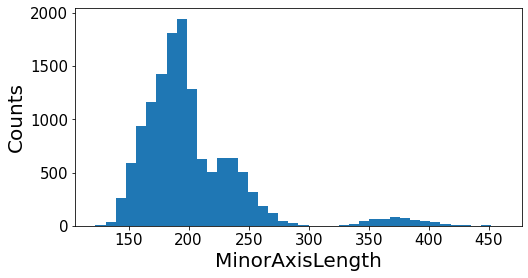

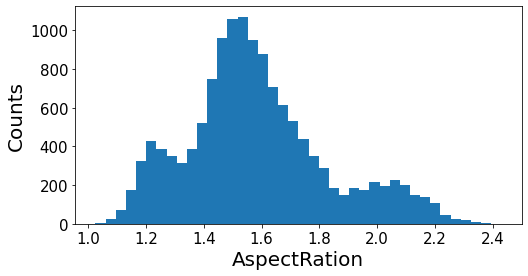

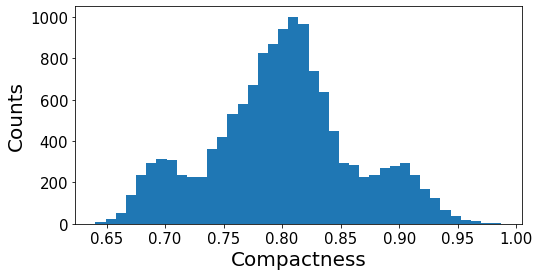

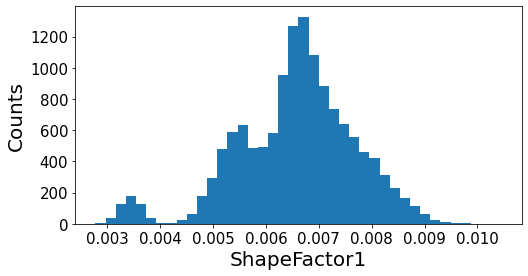

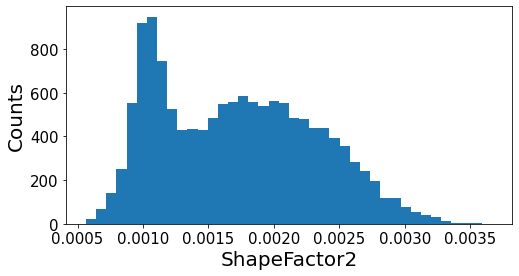

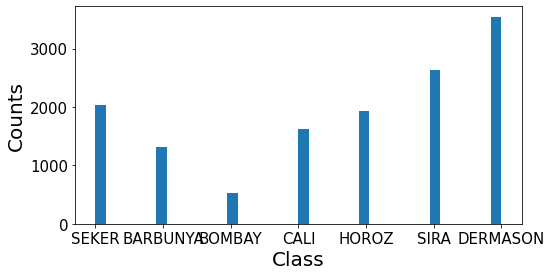

In [26]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in subsetDF.columns:
    makeHistogram(item)

### Transformations

In [27]:
# Create a new DataFrame for data transformations
transformDF = subsetDF.copy()

In [28]:
# Check the skew of each feature to determine if it requires transformation
transformDF.skew()

MinorAxisLength    2.238211
AspectRation       0.582573
Compactness        0.037115
ShapeFactor1      -0.534141
ShapeFactor2       0.301226
dtype: float64

#### Right Skew: Log(10)

In [29]:
# Features with large right skew (> 1)
transformDF.skew()[transformDF.skew() > 1]

MinorAxisLength    2.238211
dtype: float64

In [30]:
# Get a list of the columns for log-transformation
pos_skew = transformDF.skew()[transformDF.skew() > 1].index.tolist()
pos_skew

['MinorAxisLength']

In [31]:
# Apply a log10-tranformation to right-skewed columns
for item in pos_skew:
    transformDF[item] = np.log10(transformDF[item])

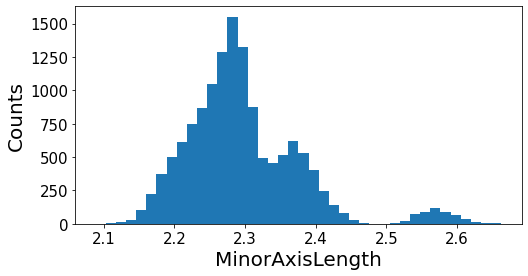

In [32]:
makeHistogram('MinorAxisLength', df=transformDF)

#### Left Skew: Cube

In [33]:
# Features with large left skew (< -1)
transformDF.skew()[transformDF.skew() < -1]

Series([], dtype: float64)

In [34]:
# Get a list of the columns for cube tranformation
neg_skew = transformDF.skew()[transformDF.skew() < -1].index.tolist()
neg_skew

[]

In [35]:
# Apply a cube-tranformation to left-skewed columns
for item in neg_skew:
    transformDF[item] = transformDF[item]**3

No Features with a large left skew to transform.

In [36]:
# Take a look at the transformed data set
transformDF.head()

,MinorAxisLength,AspectRation,Compactness,ShapeFactor1,ShapeFactor2,Class
0,2.240271,1.197191,0.913358,0.007332,0.003147,SEKER
1,2.261820,1.097356,0.953861,0.006979,0.003564,SEKER
2,2.245343,1.209713,0.908774,0.007244,0.003048,SEKER
3,2.261302,1.153638,0.928329,0.007017,0.003215,SEKER
4,2.279391,1.060798,0.970516,0.006697,0.003665,SEKER


### Create Dummy Variables

#### Encode Target Variable

In [37]:
## ENCODE CATEGORICAL TARGET COLUMN, 'Class'

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Create coded column
class_encoded = ord_enc.fit_transform(transformDF[['Class']])
class_encoded

array([[5.],
       [5.],
       [5.],
       ...,
       [3.],
       [3.],
       [3.]])

#### Create Dummy Variables from Target Variable

In [38]:
# Get the categorical data
class_df = transformDF['Class']

# One Hot Encoding 
class_dummies = pd.get_dummies(class_df)

# Check the data
class_dummies.head()

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


## Training

First, let's take a look at the transformed data set to see how it performs:

In [39]:
df = transformDF

### Split Data into Training and Testing Sets

In [40]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [41]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [42]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [43]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [44]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

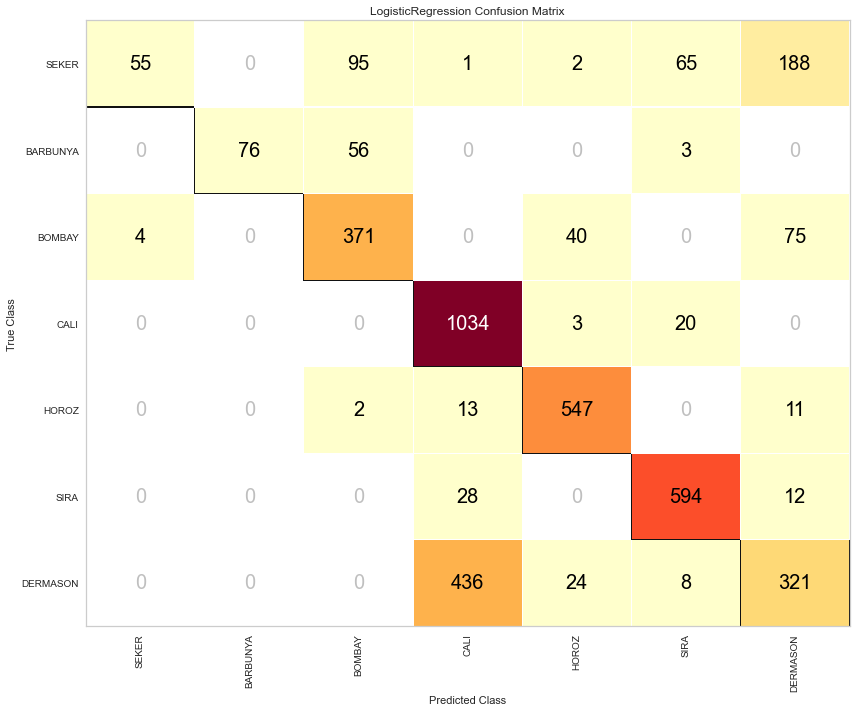

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [45]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

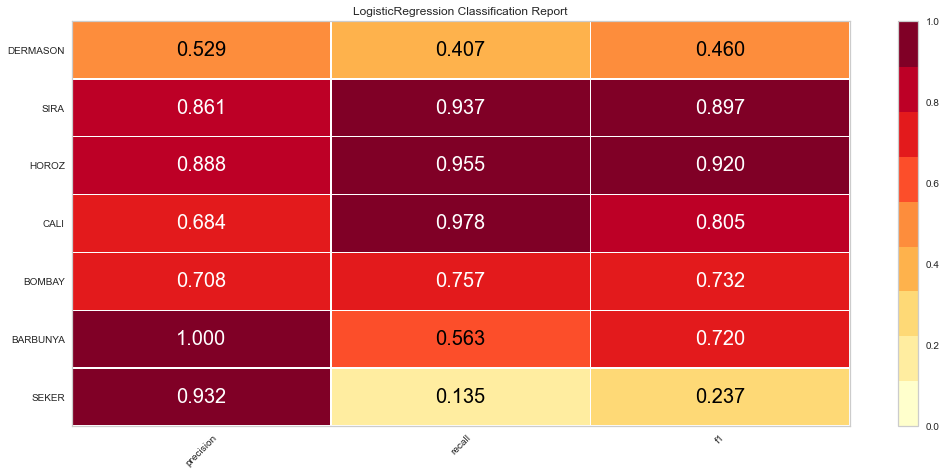

In [46]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

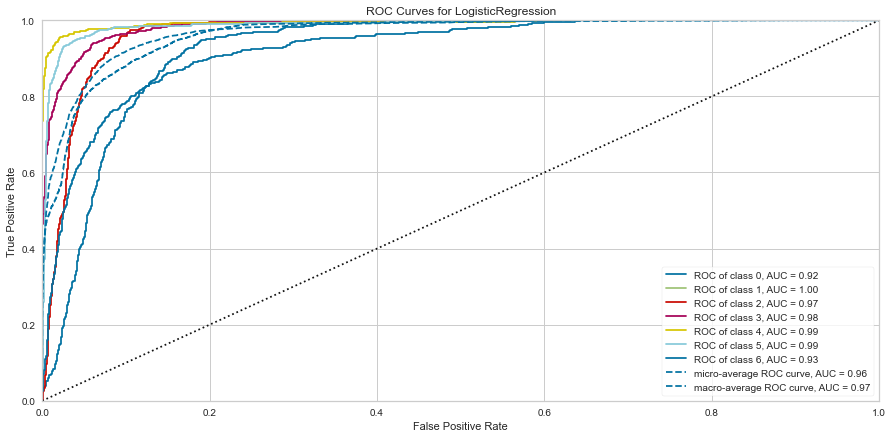

In [47]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

Not too bad, but let's look at the non-tranformed data:

## Training

In [48]:
df = subsetDF

### Split Data into Training and Testing Sets

In [49]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [50]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [51]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [52]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [53]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

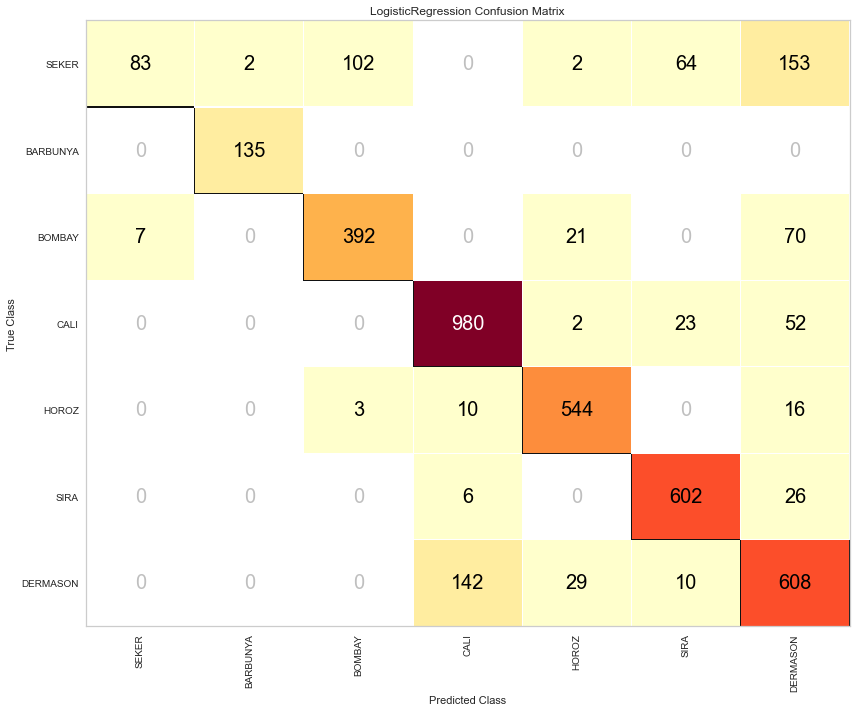

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [54]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

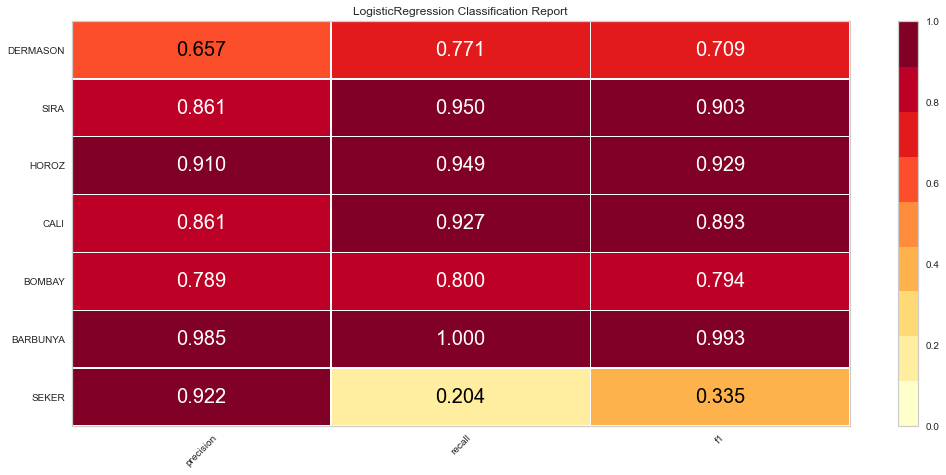

In [55]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

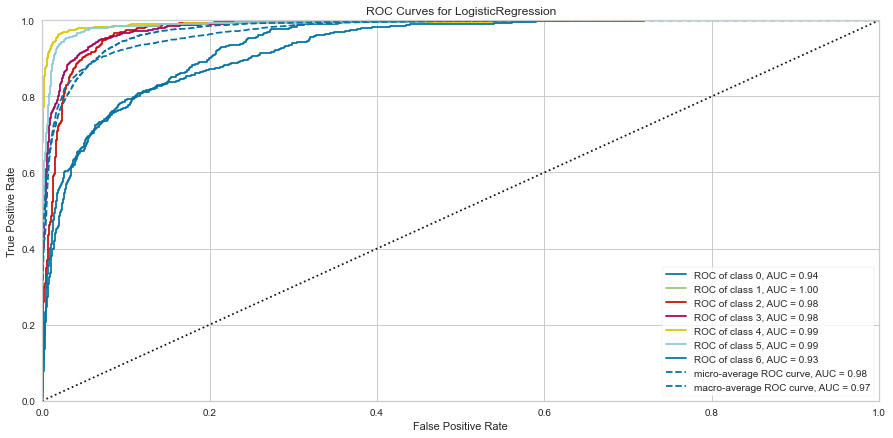

In [56]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

Interestingly, this is better. Let's try again on the original (entire) data set to see how that performs:

## Training

In [57]:
df = beanDF

### Split Data into Training and Testing Sets

In [58]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [59]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [60]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [61]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [62]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

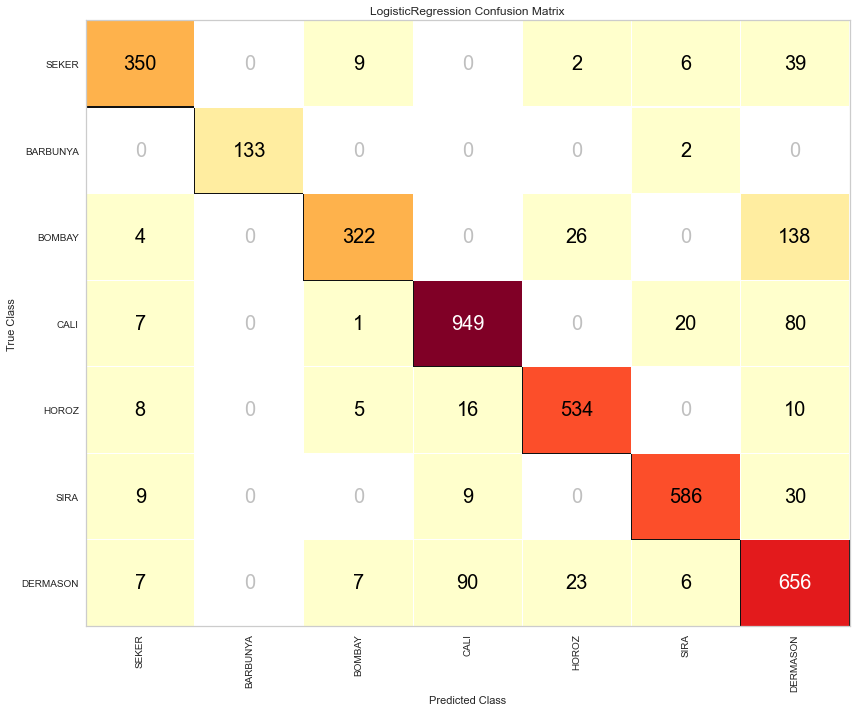

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [63]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

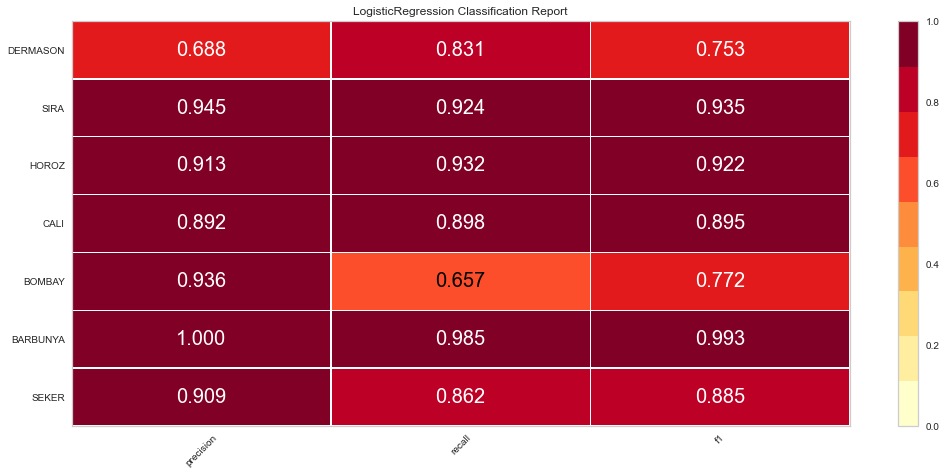

In [64]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

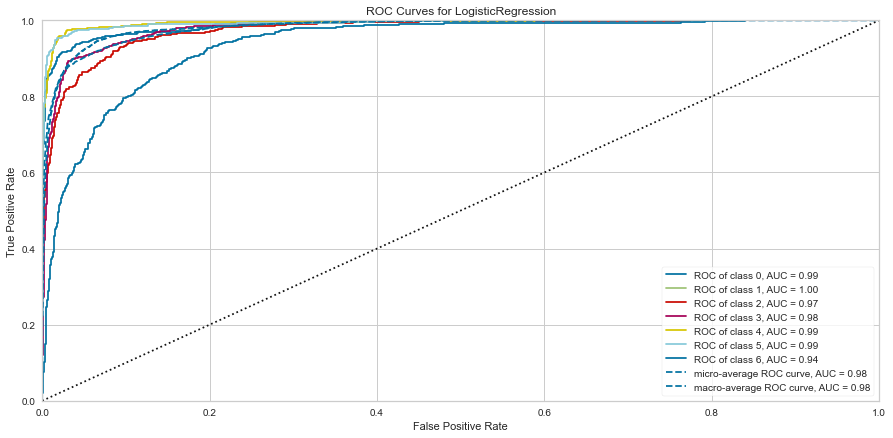

In [65]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

This looks even better yet. Maybe my methods for selecting features weren't ideal. 

At this point, I tried using just the most useful feature ('ShapeFactor2') as determined at the recursive feature selection step. Unfortunately, the model only predicted a single bean, so I went down the list (according to "usefulness") adding features back until the model started predicting all beans, which was at 11 features.  

To simplify things, I set up a loop to run through adding back in features 11-15 and showing the Precision, Recall, and F1 Score table for each so that I can more quickly compare them:

In [66]:
def prec_rec_f1(df):
    '''Creates a model and outputs Precision, Recall, & F1
    table based on DataFrame input.'''

    # Combine the numerical features and the dummy features together
    features_model = df.columns[:-1].tolist()
    data_model_X = df[features_model]

    # Create a whole target dataset that can be used for train and validation data splitting
    data_model_y = df.Class
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                      test_size =0.3, random_state=11)
    
    # Instantiate the classification model 
    model = LogisticRegression(solver='liblinear')
    classes = df.Class.unique().tolist()
    
    # Instantiate the visualizer
    visualizer = ClassificationReport(model, classes=classes)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_val, y_val)  # Evaluate the model on the test data
    g = visualizer.poof()

Top 11 features:


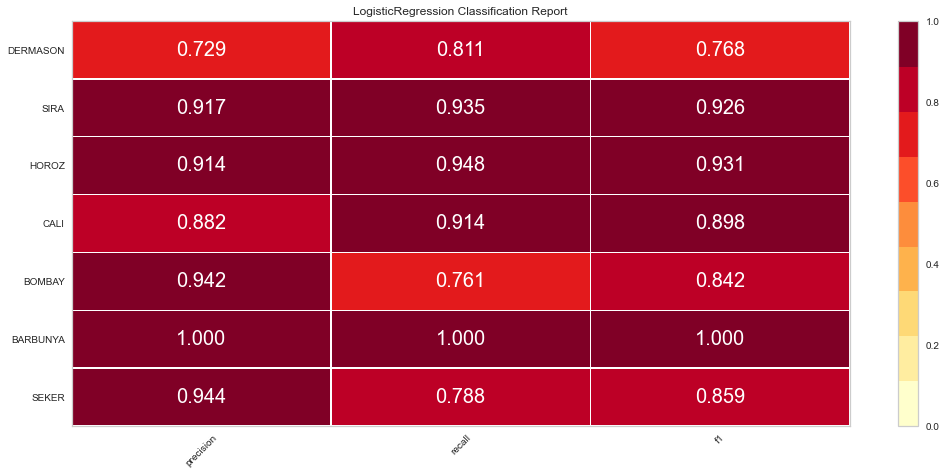

Top 12 features:


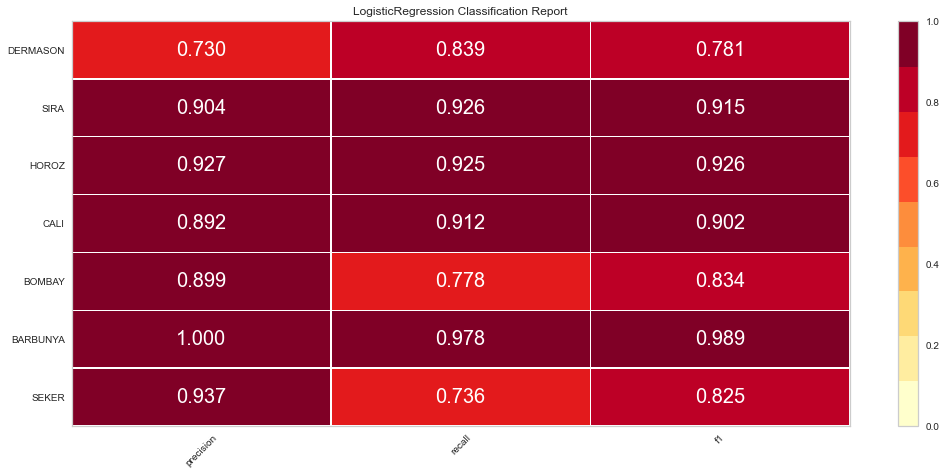

Top 13 features:


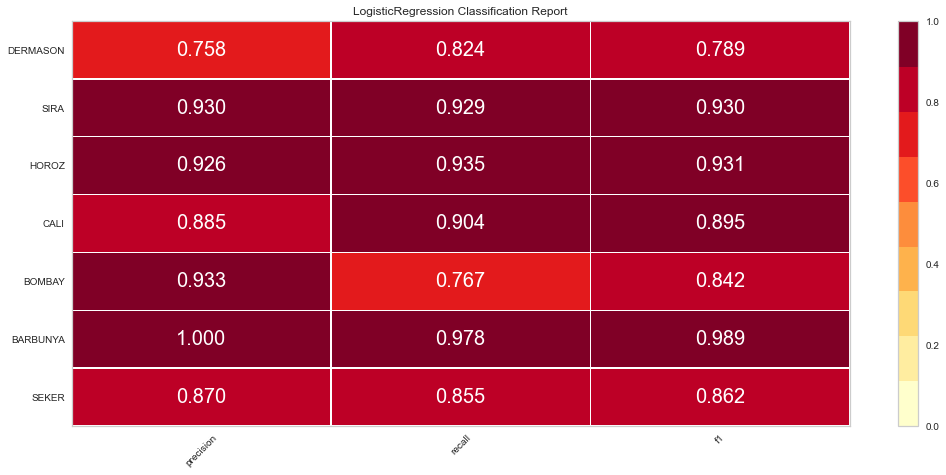

Top 14 features:


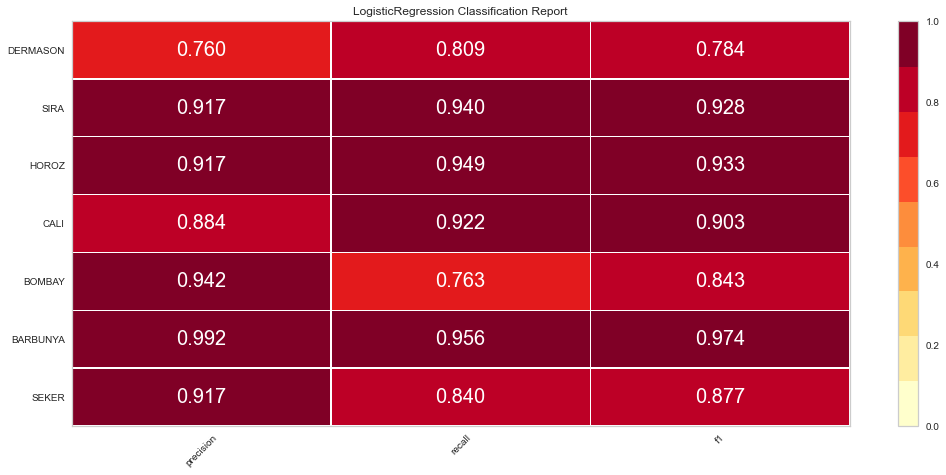

Top 15 features:


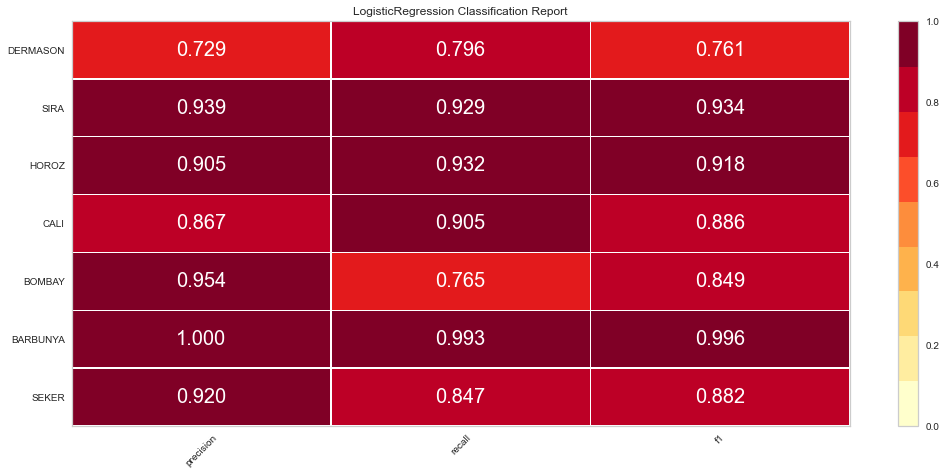

In [67]:
# Set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20
    
for i in np.arange(11, 16):
    feat_list = ranked.Features[:i].tolist() + ['Class']
    df = beanDF[feat_list]
    print(f"Top {i} features:")
    prec_rec_f1(df)

It appears that we peak at the top 12 features before our scores start going back down, so I'm going to create a 'bestDF' DataFrame with just those features and move on.

In [68]:
# Create a DataFrame with the 12 'best' features
feat_list = ranked.Features[:12].tolist() + ['Class']
bestDF = beanDF[feat_list]

In [69]:
beanDF.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

Again looking back at the counts, it would appear that the categories with the most ('DERMASON') and the least ('BOMBAY') observations generally are the categories which score the lowest. I don't know if that's related, but it is something to look back into later.

## Evaluate Models

### Evaluate Using Cross-Validation
(See Machine Learning 11.1)

In [70]:
# Load libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [71]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [72]:
# Create standardizer
standardizer = StandardScaler()

# Create logistic regression object
logit = LogisticRegression()

# Create a pipeline that standardizes, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)

# Create a k-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [73]:
%%time
# Conduct k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

Wall time: 10.3 s


In [74]:
# Calculate mean
cv_results.mean()

0.923957830954824

These results look promising. 

### Compare to a Baseline Classification Model
(See Machine Learning 11.1)

In [75]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [76]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [77]:
# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0)

In [78]:
# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)

# Get accuracy score
print("Baseline accuracy:", dummy.score(features_test, target_test))

Baseline accuracy: 0.14810461357625623


#### Compare baseline to trained classifier

In [79]:
# Load library
from sklearn.ensemble import RandomForestClassifier

In [80]:
# Create classifier
classifier = RandomForestClassifier()

# Train model
classifier.fit(features_train, target_train)

# Get accuracy score
print("Model accuracy:", classifier.score(features_test, target_test))

Model accuracy: 0.9247722597707905


### Evaluate a Clustering Model
(See Machine Learning 11.9)

In [81]:
# Load libraries
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [82]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [83]:
# Cluster data using k-means to predict classes
model = KMeans(n_clusters=2, random_state=1).fit(features)

# Get predicted classes
target_predicted = model.labels_

# Evaluate model
print("Silhouette score:", silhouette_score(features, target_predicted))

Silhouette score: 0.6254002946299253


That score is pretty low. Perhaps clustering is not an ideal model.

### Look at the Effect of Training Set Size
(See Machine Learning 11.11)

In [84]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

In [85]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [86]:
%%time
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(# Classifier
                                                        RandomForestClassifier(),
                                                        # Feature matrix
                                                        features,
                                                        # Target vector
                                                        target,
                                                        # Number of folds
                                                        cv=10,
                                                        # Performance metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # Sizes of 50
                                                        # training set
                                                       train_sizes=np.linspace(
                                                       0.01,
                                                       1.0,
                                                       50))

Wall time: 5min 13s


In [87]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [88]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

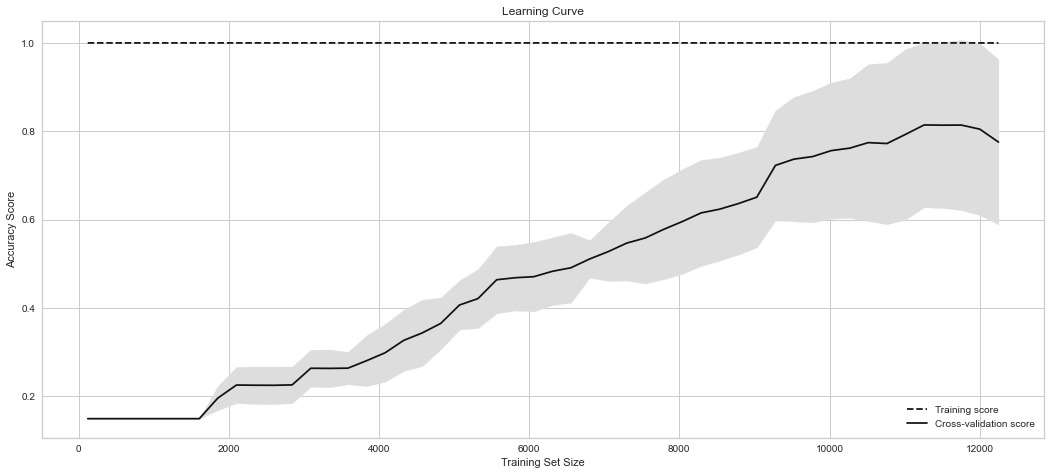

In [89]:
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()

The accuracy continues to increase as we add ovservations. This model may benefit from additional data.

### Select the Best Hyperparameters for the Model
(See Machine Learning 12.1)

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
# Load libraries
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

In [92]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [93]:
%%time
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

# Create dictionary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 1min 19s


In [94]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


In [95]:
best_model.best_score_

0.8108975626841101

Looks like 'l2' penalty with a 'C' value of 21.54 is ideal for this model.  
Out of curiosity, let's try it with the original data set:

In [96]:
# Create features matrix
features_cols = beanDF.columns[:-1].tolist()
features = beanDF[features_cols]

# Create target vector
target = beanDF.Class

In [97]:
%%time
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

# Create dictionary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 51.4 s


In [98]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [99]:
best_model.best_score_

0.6293592045122468

Scored much worse, but still seeing 'l2' as the best penalty parameter so that's probably the way to go moving forward.

### Compare Learning Algorithms (Logistic Regression and Random Forest)
(See Machine Learning 12.3)

In [100]:
# Load libraries
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [101]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [102]:
%%time
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'], # ['l1', 'l2'],  # Set based on previous steps
                 "classifier__C": [21.54]}, # np.logspace(0, 4, 10)},  # Set based on previous steps
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_features": [1, 2, 3]}]

# Create grid search
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 6min 38s


In [103]:
# View best model
best_model.best_estimator_.get_params()["classifier"]

LogisticRegression(C=21.54)

It appears that Logistic Regression is a better model for this data than a Random Forest Classifier.

As I work though, I keep finding new things to try and realize that I still have a fair amount of work to do. For example I found when selecting preprocessing parameters that I should try reducing features using principal components (PCA) and I have some tuning to do around training a multiclass classifier, including comparing 'multinomial' to 'ovr' for the `multiclass_class=` parameter.